In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.utils import shuffle
from ctgan import CTGAN 

# Nettoyage des données

In [2]:
data = pd.read_csv("./data/train.csv")

# Filter all duplicates 
data = data.drop(columns=["SNo"]).drop_duplicates()

# Remove ALL rows with same set of features but different label
duplicate_mask = data.drop(columns="Label").duplicated(keep=False)
data = data[~duplicate_mask].reset_index(drop=True)
data = data.rename(columns={"lat" : "LAT", 'lon' : "LON"})
data.head(5)

,LAT,LON,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
0,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,20031024,1
1,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,20031024,1
2,21.707953,275.3125,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,98175.43750,224.642563,272.152283,0.000010,302.462708,300.160187,66.880089,12386.88574,66.275246,20031024,1
3,21.473272,275.3125,76.771362,-33.228142,57.195755,-46.387169,25.953285,0.022245,97758.07031,97758.10938,225.363648,271.941498,0.000009,302.462708,300.021759,66.232269,12359.41309,66.228661,20031024,1
4,21.707953,275.6250,74.268501,-37.684723,42.142948,-41.747562,14.927589,0.022106,98841.56250,98852.13281,222.947571,271.887268,0.000007,302.462708,300.101929,67.174088,12392.40234,66.251289,20031024,1


# Transformation des données difficiles à synthétiser, en cas plus simples généralisables

### Clustering sur les emplacements par latitude et longitude

In [3]:
import hdbscan
import pandas as pd
import numpy as np

def cluster_data(df):
    # Define a cluster selection epsilon to group points within this distance.
    # In this case, it's 10 meters (0.01 km divided by the radius of the Earth).
    eps = 400 / 6378

    # Initiate HDBSCAN clusterer
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100,
                                metric='haversine',
                                cluster_selection_epsilon=eps)

    # Convert coordinates to radians for distance-based grouping and cluster them
    clusterer.fit(np.radians(df[['LAT', 'LON']]).values)

    # Return the cluster labels for each point
    return clusterer.labels_
    

def plot_clusters(df, labels):
    # Create a scatter plot
    plt.scatter(df['LON'], df['LAT'], c=labels, cmap='rainbow', s=50)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('HDBSCAN Clustering')
    plt.colorbar()
    plt.show()

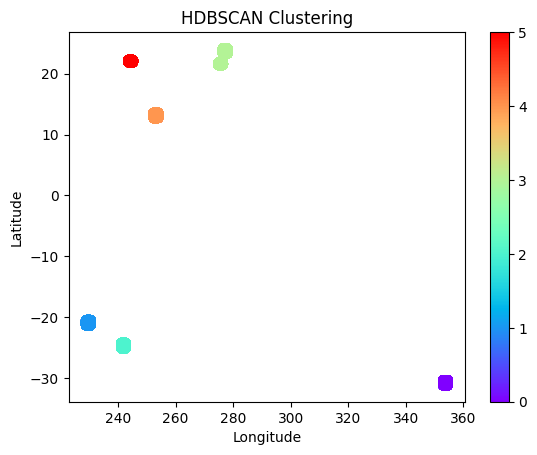

In [4]:
labels = cluster_data(data)
data["LOCATION"] = labels
plot_clusters(data, labels)

In [5]:
# UTILE DANS FEATURE_EGINEERING
location_coordinate_relation = data[["LOCATION", "LAT", "LON"]].drop_duplicates().groupby("LOCATION").mean()
location_coordinate_relation

,LAT,LON
LOCATION,,
0,-30.743155,353.750000
1,-20.886571,229.687500
2,-24.641460,241.875000
3,22.998696,276.666667
4,13.142112,253.125000
5,22.059974,244.375000


In [11]:
# UTILE POUR OBTENIR LES LOCATIONS SUR LE JEU TEST
location_dict = data.groupby('LOCATION').apply(lambda x: list(set((lat, lon) for lat, lon in zip(x['LAT'], x['LON'])))).to_dict()
location_dict

{0: [(-31.09517601, 353.75),
  (-31.09517601, 353.4375),
  (-31.09517601, 353.125),
  (-30.62581486, 353.125),
  (-30.62581486, 353.4375),
  (-30.62581486, 353.75),
  (-30.86049544, 354.0625),
  (-30.86049544, 354.375),
  (-30.39113429, 354.375),
  (-30.39113429, 354.0625),
  (-30.86049544, 353.75),
  (-30.86049544, 353.4375),
  (-30.86049544, 353.125),
  (-30.39113429, 353.125),
  (-30.39113429, 353.4375),
  (-30.39113429, 353.75),
  (-31.09517601, 354.375),
  (-31.09517601, 354.0625),
  (-30.62581486, 354.375),
  (-30.62581486, 354.0625)],
 1: [(-21.00391134, 229.6875),
  (-21.00391134, 229.375),
  (-21.00391134, 229.0625),
  (-20.5345502, 229.6875),
  (-20.5345502, 229.375),
  (-20.5345502, 229.0625),
  (-21.23859192, 230.3125),
  (-21.23859192, 230.0),
  (-20.76923077, 230.0),
  (-20.76923077, 230.3125),
  (-21.23859192, 229.375),
  (-21.23859192, 229.6875),
  (-21.23859192, 229.0625),
  (-20.76923077, 229.375),
  (-20.76923077, 229.6875),
  (-20.76923077, 229.0625),
  (-21.0039113

### Séparation "time" en Année, Mois et Jour

In [7]:
data['YEAR'] = data['time'].apply(lambda x: int(str(x)[:4]))
data['MONTH'] = data['time'].apply(lambda x: int(str(x)[4:6]))
data['DAY'] = data['time'].apply(lambda x: int(str(x)[6:]))

### Transformation de l'échelle de mesure de PRECT de (m/s) à (mm/h)

In [9]:
data["PRECT"] = data["PRECT"] * 3600 * 1000

In [10]:
data = data.drop(columns=["LAT", "LON", "time"])
data.head(5)

,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,...,TS,TREFHT,Z1000,Z200,ZBOT,Label,LOCATION,YEAR,MONTH,DAY
0,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,...,302.350861,300.026764,66.339836,12400.22754,66.241585,1,3,2003,10,24
1,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,...,302.350861,299.798828,66.165573,12371.33203,66.165268,1,3,2003,10,24
2,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,98175.43750,224.642563,272.152283,...,302.462708,300.160187,66.880089,12386.88574,66.275246,1,3,2003,10,24
3,76.771362,-33.228142,57.195755,-46.387169,25.953285,0.022245,97758.07031,97758.10938,225.363648,271.941498,...,302.462708,300.021759,66.232269,12359.41309,66.228661,1,3,2003,10,24
4,74.268501,-37.684723,42.142948,-41.747562,14.927589,0.022106,98841.56250,98852.13281,222.947571,271.887268,...,302.462708,300.101929,67.174088,12392.40234,66.251289,1,3,2003,10,24


# Génération d'exemples synthétiques

In [14]:
data_label0 = data[data['Label'] == 0]
data_label1 = data[data['Label'] == 1]
data_label2 = data[data['Label'] == 2]

data_label0_downsampled = resample(data_label0, replace=False, n_samples=4000, random_state=50)

In [15]:
from ctgan import CTGAN

# Define the number of synthetic samples needed
synthetic_samples_needed_1 = 4000 - data_label1.shape[0]
synthetic_samples_needed_2 = 4000 - data_label2.shape[0]

discrete_columns = [
    'LOCATION',
    'YEAR',
    'MONTH',
    'DAY',
    'Label'
]

In [16]:
# Initialize and train CTGAN for label 1
ctgan_1 = CTGAN(epochs=2000, verbose=True, cuda=True)  # Reduced epochs for time efficiency
ctgan_1.fit(data_label1, discrete_columns)
synthetic_1 = ctgan_1.sample(synthetic_samples_needed_1)

Gen. (-0.08) | Discrim. (-0.34): 100%|██████████| 2000/2000 [03:54<00:00,  8.51it/s]


In [17]:
# Initialize and train CTGAN for label 2
ctgan_2 = CTGAN(epochs=2000, verbose=True, cuda=True)  # Reduced epochs for time efficiency
ctgan_2.fit(data_label2, discrete_columns)
synthetic_2 = ctgan_2.sample(synthetic_samples_needed_2)

Gen. (-0.47) | Discrim. (-0.07): 100%|██████████| 2000/2000 [20:50<00:00,  1.60it/s]


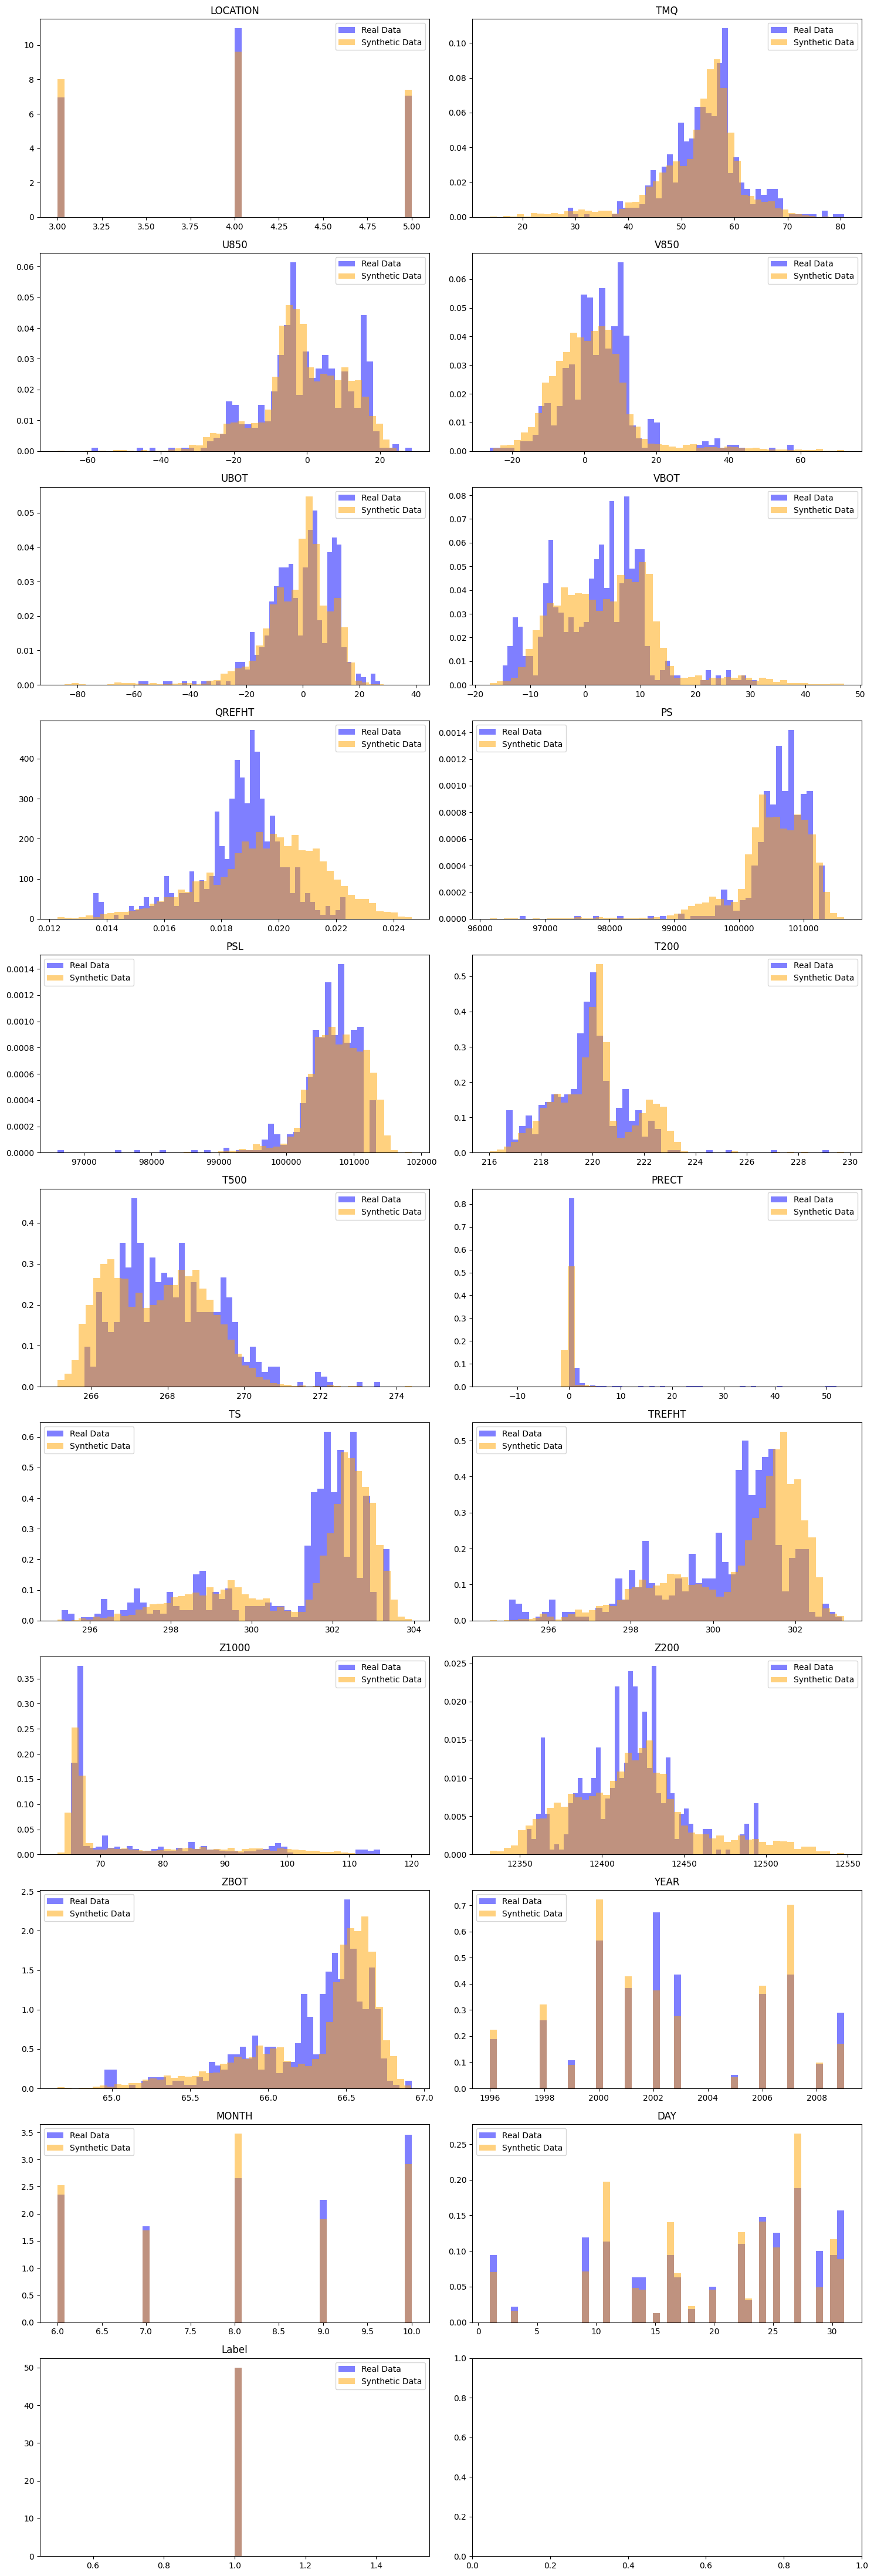

In [19]:
# Assuming you already have your dataframes: data_label1 and synthetic_1
features = [
    'LOCATION', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 
    'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT',
    'YEAR', 'MONTH', 'DAY', 'Label'
]

# Create a figure with subplots
n_features = len(features)
n_cols = 2
n_rows = n_features // n_cols + (n_features % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Flatten the axes in case it's a 2D array
axes = axes.flatten()

# Loop through each feature and plot the real and synthetic data densities
for i, feature in enumerate(features):
    axes[i].hist(data_label1[feature], bins=50, color="blue", alpha=0.5, label="Real Data", density=True)
    axes[i].hist(synthetic_1[feature], bins=50, color="orange", alpha=0.5, label="Synthetic Data", density=True)
    axes[i].set_title(feature)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

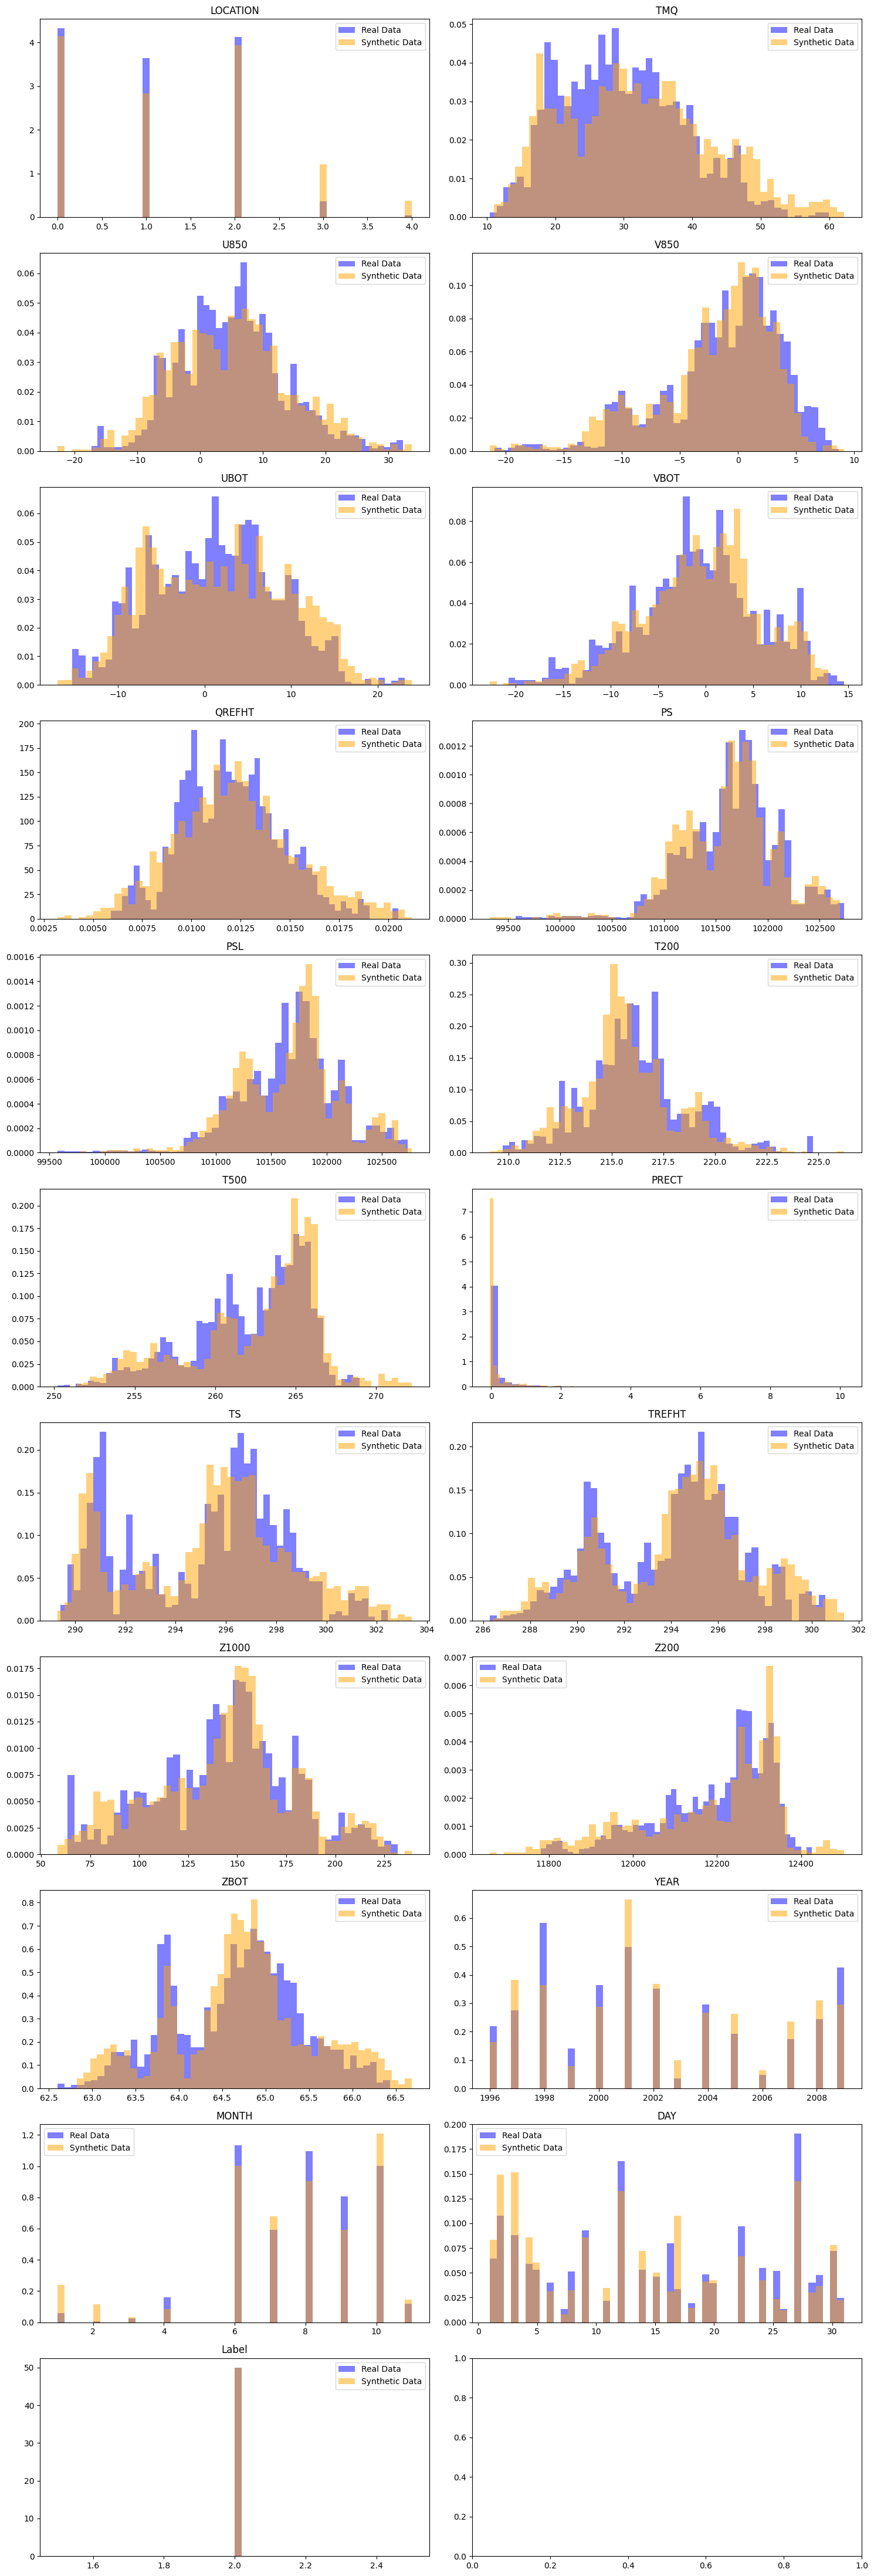

In [20]:
# Assuming you already have your dataframes: data_label1 and synthetic_1
features = [
    'LOCATION', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 
    'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT',
    'YEAR', 'MONTH', 'DAY', 'Label'
]

# Create a figure with subplots
n_features = len(features)
n_cols = 2
n_rows = n_features // n_cols + (n_features % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Flatten the axes in case it's a 2D array
axes = axes.flatten()

# Loop through each feature and plot the real and synthetic data densities
for i, feature in enumerate(features):
    axes[i].hist(data_label2[feature], bins=50, color="blue", alpha=0.5, label="Real Data", density=True)
    axes[i].hist(synthetic_2[feature], bins=50, color="orange", alpha=0.5, label="Synthetic Data", density=True)
    axes[i].set_title(feature)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Sauvegarde du jeu de données nettoyé et augmenté

In [ ]:
data = pd.concat([data_label0_downsampled, data_label1, synthetic_1, data_label2, synthetic_2]).reset_index(drop=True)
data = shuffle(data, random_state=42)
data.to_csv("./data/augmented_train.csv")